In [1]:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pathlib
import random
import sys
sys.path.append("./../")
from src.utils import load_data, prep_data, predict_and_plot_SLC

import seaborn as sns
plt.style.use('seaborn-whitegrid')
sns.set_palette('colorblind')
mpl.rcParams['font.family'] = 'Arial'

In [2]:
# Load data 
data = load_data([0,176])
sample_size = 3000 # TEST SIZE, if you want real plots s=3000

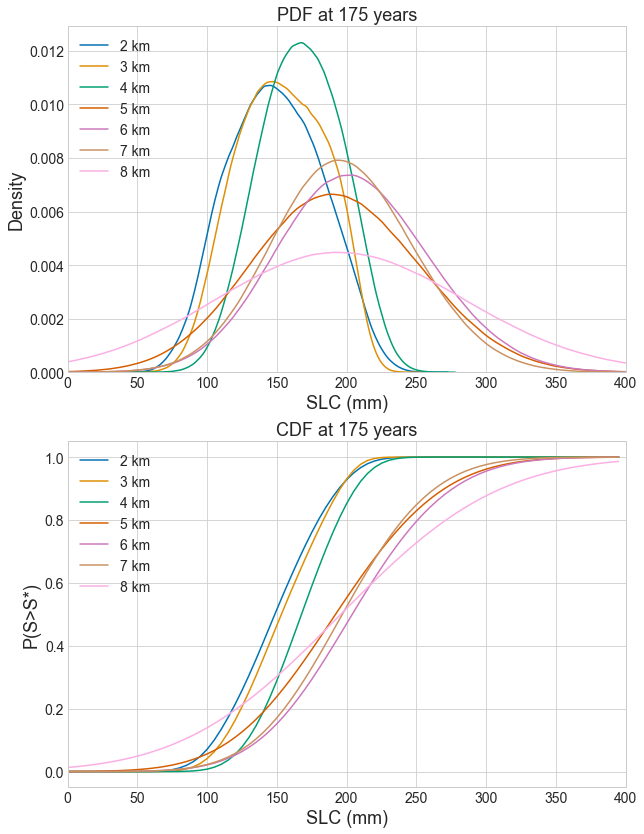

In [4]:
# Figure 4: this can take > 10 minute to run 
timestamp_list = [100,125,150,175] # 
max_val_list= [150,200,300,400]
for timestamp, max_val_un in zip(timestamp_list, max_val_list):
    predictions = [predict_and_plot_SLC(data, timestamp, max_val_un, i, plot=False, sample_size=sample_size) for i in range(2,9)]
    opt = None
    plt.figure(figsize=(10,14))
    for r,i in zip(range(2,9), predictions):
        mean,var = i[1]
        data_list = []
        for m,v in zip(mean,var):
            data_list += list(np.random.normal(m,np.sqrt(v),size=sample_size))
            
        plt.subplot(2,1,1)
        sns.kdeplot(np.array(data_list),label=str(r)+" km")

        plt.subplot(2,1,2)
        x = []
        y = []
        for thres in range(0,max_val_un,5):
            x.append(thres)
            y.append(len([i for i in data_list if i > thres])/len(data_list))
        if opt == None:
            opt = y
        plt.plot(x,[1-i for i in y],label=str(r)+" km")

    plt.subplot(2,1,1)
    plt.xlim(0, max_val_un)
    plt.xlabel("SLC (mm)",fontsize=18)
    plt.ylabel("Density",fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.title(f"PDF at {timestamp} years",fontsize=18)
    plt.legend(fontsize=14,loc='upper left')
    plt.subplot(2,1,2)
    plt.xlim(0, max_val_un)
    plt.xlabel("SLC (mm)",fontsize=18)
    plt.ylabel("P(S>S*)",fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(fontsize=14,loc='upper left')
    plt.title(f"CDF at {timestamp} years",fontsize=18)
    plt.savefig(f"./../assets/plots/fig_4/cdf_pdf_{timestamp}.pdf",bbox_inches='tight')